<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/main/notebooks/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Implementation Remote Sensing

## Import necessary packages

In [1]:
!pip install rasterio
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl
import glob
from pathlib import Path
from math import floor
import random

# import data reader, logging and transforms
from torchvision import transforms
from torchvision import datasets
import rasterio as rio
from rasterio.plot import reshape_as_image
import wandb

# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils

# import matplotlib and enabling notebook inline plotting:
import matplotlib.pyplot as plt

%matplotlib inline

Mount Google Drive Directories for data access

In [3]:
# import the Google Colab GDrive connector
from google.colab import drive

# mount GDrive inside the Colab notebook
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# create Colab Notebooks directory
notebook_directory = Path("/content/drive/MyDrive/Projects/DeepLearning")
if not os.path.exists(notebook_directory):
    os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
data_directory = Path("/content/drive/MyDrive/Projects/DeepLearning/data")
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
models_directory = Path("/content/drive/MyDrive/Projects/DeepLearning/models")
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

## Helper Functions

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu").type

print("[LOG] notebook with {} computation enabled".format(str(device)))

[LOG] notebook with cuda computation enabled


In [6]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

## Data

Define the directory on your drive to reproduce results. Downloaded data from https://madm.dfki.de/files/sentinel/EuroSATallBands.zip should be within the data folder created in previous steps. 

In [7]:
IMAGE_SIZE = 64
transformer_train = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Resize(IMAGE_SIZE),
        # transforms.CenterCrop(IMAGE_SIZE),
        # transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
    ]
)

transformer_test = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Resize(IMAGE_SIZE),
        # transforms.CenterCrop(IMAGE_SIZE),
        # transforms.Normalize([87.81586935763889, 96.97416420717593, 103.98142336697049], [51.67849701591506, 34.908630837585186, 29.465280593587384]),
    ]
)

In [8]:
torchvision_eurosat_dir = data_directory.joinpath("eurosat")
data = datasets.EuroSAT(
    root=torchvision_eurosat_dir, transform=transformer_train, download=True
)

In [9]:
data[0]

(tensor([[[0.5843, 0.5765, 0.5725,  ..., 0.4000, 0.4078, 0.4039],
          [0.5843, 0.5843, 0.5843,  ..., 0.4000, 0.4078, 0.4039],
          [0.5608, 0.5647, 0.5765,  ..., 0.4000, 0.4000, 0.4039],
          ...,
          [0.5529, 0.5529, 0.5373,  ..., 0.4039, 0.3922, 0.3961],
          [0.5098, 0.5176, 0.5059,  ..., 0.4118, 0.4118, 0.4196],
          [0.4784, 0.4784, 0.4706,  ..., 0.4157, 0.4157, 0.4196]],
 
         [[0.4745, 0.4745, 0.4706,  ..., 0.3529, 0.3608, 0.3569],
          [0.4745, 0.4745, 0.4667,  ..., 0.3529, 0.3608, 0.3569],
          [0.4588, 0.4510, 0.4549,  ..., 0.3608, 0.3529, 0.3569],
          ...,
          [0.4588, 0.4588, 0.4588,  ..., 0.3647, 0.3529, 0.3529],
          [0.4353, 0.4392, 0.4314,  ..., 0.3686, 0.3647, 0.3725],
          [0.4157, 0.4118, 0.4039,  ..., 0.3725, 0.3725, 0.3725]],
 
         [[0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
          [0.4706, 0.4706, 0.4667,  ..., 0.3922, 0.4000, 0.3961],
          [0.4549, 0.4588, 0.4745,  ...,

In [10]:
classes = {
    0: "AnnualCrop",
    1: "Forest",
    2: "HerbaceousVegetation",
    3: "Highway",
    4: "Industrial",
    5: "Pasture",
    6: "PermanentCrop",
    7: "Residential",
    8: "River",
    9: "SeaLake",
}

In [11]:
class_to_idx = {value: key for key, value in classes.items()}

In [12]:
print(class_to_idx)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


Create a user-defined data loader for the EuroSAT data to adjust specifically for a GAN model. This process includes transformations if wanted. 

## Setup GAN 
The GAN architecture is composed of the generative model $G$ and the discriminative model $D$.

The discriminator $D$ is a binary classifier trying to determine whether the input sample $X$ is real or fake. Real pictures come from the EuroSAT dataset whereas fake inputs are generated by generator $G$. Thus, $D$ outputs a scalar which is then transformed to a probability measure using the sigmoid function. 

- 1 - Sample is part of the real dataset
- 0 - Sample is a fake generated by $G$

In a first case we try to implement the DC-GAN as in ([PyTorch DC-GAN](https://https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html))

In [13]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

### Discriminator
Due to the binary classification case of the discriminator we will use the BCE with logits loss because cross entropy not only punishes incorrect but confident predictions but also correct but less confident predictions. Including the logits there is no need to apply the sigmoid activation function in the network. 

In [15]:
# implement the Discriminator network architecture
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

### Generator
As the generator is not a discriminative model its aim is to generate data. 
Thus, we draw the latent variable $z \in \mathbb{R}^d$ from a random distribution such as a Gaussian or a uniform distribution. 
Accordingly, $G$ produces the following output: $X' = G(z)$. 
As we want to fool $D$ to fail in distinguishing fake and real remote sensing data we aspire $D(G(z)) ≈ 1$. Hence, the goal is to maximize cross-entropy loss in case $y=0$ (fake data). 

In [16]:
# implement the Generator network architecture


class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

### MinMax-Game
We thus define the following value function $V$ by combining both the targets of $G$ and $D$:

$$min_{G}max_{D} V(D, G) = \mathbb{E}_{x∼Data} [logD(x)] + \mathbb{E}_{z∼Noise} [log(1-D(G(z)))]$$


In [17]:
# instantiate both D and G
D = Discriminator(ngpu).to(device)
G = Generator(ngpu).to(device)

In [18]:
# initialize the weights
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [19]:
# check whether model is loaded to GPU
!nvidia-smi

Fri Oct 14 07:04:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |    652MiB / 15109MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [20]:
print("[LOG] Discriminator architecture:\n\n{}\n".format(D))

[LOG] Discriminator architecture:

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
 

In [21]:
print("[LOG] Generator architecture:\n\n{}\n".format(G))

[LOG] Generator architecture:

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [22]:
# define the loss for the discriminator and push to device
criterion = nn.BCELoss()
criterion = criterion.to(device)

For further training tips of GANs look at: [GAN hacks](https://https://github.com/soumith/ganhacks)

In [23]:
# set learning rate
lr = 0.002

# create optimizers for the discriminator and generator
d_optimizer = optim.SGD(D.parameters(), 0.02)
g_optimizer = optim.Adam(G.parameters(), 0.002)

## Training

In [24]:
# specify the training parameters
num_epochs = 100  # number of training epochs
batch_size = 32  # size of the mini-batches

In [25]:
tv_train_dataloader = torch.utils.data.DataLoader(
    data, batch_size=batch_size, shuffle=True
)

In [26]:
# establish convention for real and fake labels during training
real_label = 1
fake_label = 0

In [27]:
# define size of latent vector
z_size = 100

# define sample size
sample_size = 4

# uniformly distribute data of size z_size over an interval of -1; 1
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [28]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(tv_train_dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = D(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        d_optimizer.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        g_optimizer.step()

        # Output training stats
        if i % 500 == 0:
            print(
                "[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(tv_train_dataloader),
                    errD.item(),
                    errG.item(),
                    D_x,
                    D_G_z1,
                    D_G_z2,
                )
            )

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or (
            (epoch == num_epochs - 1) and (i == len(tv_train_dataloader) - 1)
        ):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    if (epoch % 10 == 0) or (epoch == 99):
        # set filename of actual model
        d_model_name = "gan_d_model_epoch_{}.pth".format(str(epoch + 1))

        # set filename of actual model
        g_model_name = "gan_g_model_epoch_{}.pth".format(str(epoch + 1))

        # save current model to GDrive models directory
        torch.save(D.state_dict(), os.path.join(models_directory, d_model_name))

        # save current model to GDrive models directory
        torch.save(G.state_dict(), os.path.join(models_directory, g_model_name))

Starting Training Loop...
[0/100][0/844]	Loss_D: 1.8603	Loss_G: 13.8232	D(x): 0.4086	D(G(z)): 0.5050 / 0.0000
[0/100][500/844]	Loss_D: 0.0076	Loss_G: 7.3712	D(x): 0.9978	D(G(z)): 0.0054 / 0.0046
[1/100][0/844]	Loss_D: 0.0428	Loss_G: 7.9337	D(x): 0.9974	D(G(z)): 0.0363 / 0.0122
[1/100][500/844]	Loss_D: 0.0263	Loss_G: 8.3702	D(x): 0.9916	D(G(z)): 0.0170 / 0.0136
[2/100][0/844]	Loss_D: 0.0295	Loss_G: 6.8672	D(x): 0.9980	D(G(z)): 0.0269 / 0.0203
[2/100][500/844]	Loss_D: 0.0583	Loss_G: 6.4620	D(x): 0.9921	D(G(z)): 0.0453 / 0.0130
[3/100][0/844]	Loss_D: 4.5749	Loss_G: 5.8608	D(x): 0.6762	D(G(z)): 0.0755 / 0.0859
[3/100][500/844]	Loss_D: 0.2286	Loss_G: 5.1304	D(x): 0.9567	D(G(z)): 0.1367 / 0.0473
[4/100][0/844]	Loss_D: 4.5922	Loss_G: 0.5545	D(x): 0.1069	D(G(z)): 0.0009 / 0.6388
[4/100][500/844]	Loss_D: 1.9042	Loss_G: 9.6972	D(x): 0.9988	D(G(z)): 0.7696 / 0.0095
[5/100][0/844]	Loss_D: 0.1148	Loss_G: 4.6882	D(x): 0.9917	D(G(z)): 0.0968 / 0.0246
[5/100][500/844]	Loss_D: 1.0989	Loss_G: 2.2004	D(x

In [29]:
# save current model to GDrive models directory
torch.save(D.state_dict(), os.path.join(models_directory, "D_epoch_20"))

# save current model to GDrive models directory
torch.save(G.state_dict(), os.path.join(models_directory, "G_epoch_20"))

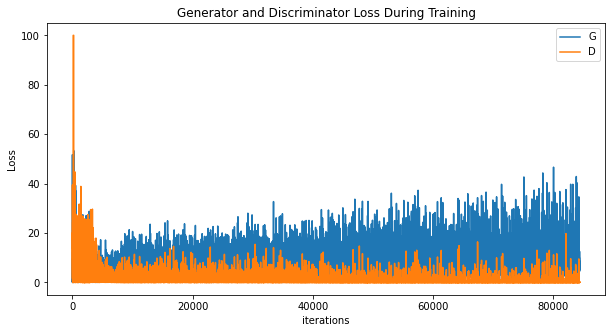

In [30]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

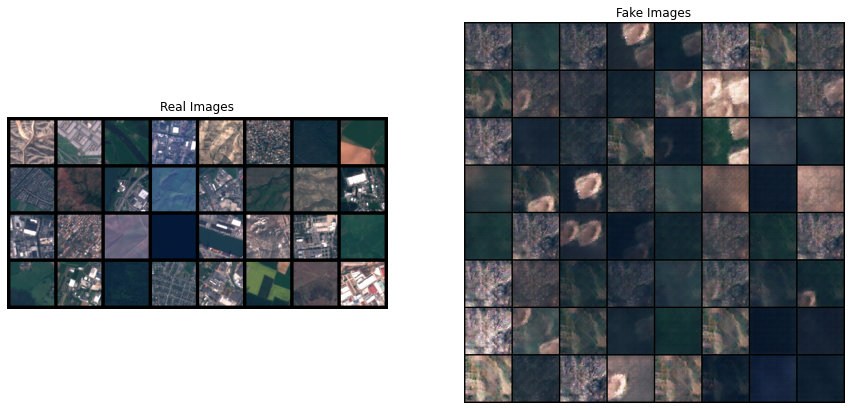

In [31]:
real_batch = next(iter(tv_train_dataloader))

# Plot the real images
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(
    np.transpose(
        vutils.make_grid(
            real_batch[0].to(device)[:64], padding=5, normalize=True
        ).cpu(),
        (1, 2, 0),
    )
)

# Plot the fake images from the last epoch
plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()